# RPZ Assignment: Convolutional Neural Networks

**Detailed BRUTE upload instructions at the end of this notebook.**

## Introduction

This lab has two parts. In the first part you will build simple neural networks (NN) in NumPy in order to get familiar with the principles typically hidden behind commonly used frameworks. This part we are trying to cover in a typical RPZ assignment style. In addition, we provide you with various links containing further explanations. You may want to use the link in case the concept is not clear of if you want to learn more. Many more useful links are included at the end of this notebook.

The second part is intentionally formulated less precisely and gives you much more freedom in exploring the topic. You will be working in the PyTorch framework which is a highly optimized library for training neural networks. To cover everything in a single notebook is not possible, so we provide a basic training procedures and ask you to learn by solving simple tasks.

And finally, there is a challenge! To pass Part 2 should not be that difficult. But can you outperform the other RPZ students on a hidden test set? We offer many bonus points and enough time to try and learn. There is no better way to learn PyTorch than trying to solve a simple problem!

In [1]:
%load_ext autoreload
%autoreload 2

from numpy_nn import *
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import numpy.testing as testing


# param for visualisation
n_data = 1001

## Part 1: Implementing a simple neural network by hand

We start by implementing a few simple layers in pure NumPy to get better understanding of what is going on in the machine learning frameworks like PyTorch, TensorFlow, etc.

Recall, that a neural network is an acyclic graph with individual nodes being either simple Perceptrons (with non-linearity) or other 'layers'. A layer is an object which has two main functions: (i) it can pass the data forward during the prediction/classification phase -- implemented in `layer.forward` method, and (ii) it computes gradients with respect to (w.r.t.) its inputs and parameters which are then passed backward during back-propagation training -- implemented in `layer.backward` method. This allows to chain many layers into very large graphs and then compute efficiently the gradient of the loss function w.r.t. every parameter. The forward pass propagates the input data through the `forward` calls in each layer sequentially from the first to the last layer. Then, starting at the last layer, the gradients are propagated backwards in the graph (with the `backward` function) down to all parameters. The basic example of backpropagation was given in the lecture. For a more detailed overview see e.g. the respective [lecture](https://youtu.be/XhduJETbSMk) of the Deep Learning course or the [lecture by Karpathy](https://youtu.be/i94OvYb6noo). After all the gradients are computed, we update the network parameters by a (stochastic) gradient descent (SGD) step and repeat the procedure.

You will see that out of all layers which we consider, only the fully-connected layer (or linear layer as we call it) has some trainable parameters.
During training, SGD updates the network parameters using partial derivatives of the loss w.r.t. the parameters.
For a layer with trainable parameters, we also need to implement a method `layer.grads` which returns the gradients of the loss w.r.t. its parameters computed in `layer.backward`.

### Fully-connected (Linear) layer

In its `forward` method, the `Linear` layer implements the function $f(\mathbf{x}) = \mathbf{x} \mathbf{W} + \mathbf{b}$ (this is PyTorch-style definition, note that it differs from the one in lecture: Wx + b). <br> **Hint**: You may need to store the inputs $x$ for later use in the `backward` method.

In the `backward` method, the gradients of the layer w.r.t. $\mathbf{W}$, $\mathbf{b}$ and the layer input are computed. The method returns only the gradient of the loss w.r.t. the layer's input.

Both `forward` and `backward` methods must work with several data samples stacked together in a tensor (these are called batches or minibatches).
Make sure that you **check your shapes against the docstring specifications!** <br>
Remember, **CHECK YOUR SHAPES!** <br>
Reshaping, adding extra dimensions or transposing the arrays may come handy (you might want to check an old [NumPy - HOW TO thread](https://cw.felk.cvut.cz/forum/thread-4609.html) at the forum).

Make sure that the gradients' computation is working for batched data and their **shapes are the same as the docstring tells you**.  If you are getting a weird error in BRUTE, it is very likely that your **shapes are wrong!**

In [2]:
# set layer params
input_dim = 3
output_dim = 2

# create instance of linear layer
linear_layer = Linear(input_dim, output_dim)

# set weights and bias of linear layer (for testing purposes)
linear_layer.W = np.array([[ 1.,   0.6],
                           [ 0.2, -0.2],
                           [-0.6, -1. ]])
linear_layer.b = np.array([[-0.5, 0.5]])

# create sample input data
batch_size = 2
x_linear = np.array([[-2.,  -1.2, -0.4],
              [ 0.4,  1.2,  2. ]])

# forward pass of linear layer
forward_output = linear_layer.forward(x_linear)

# check if the result is correct
testing.assert_array_almost_equal([[-2.5, -0.06], [-1.06, -1.5 ]], forward_output, decimal=6, err_msg='The values returned from the forward pass are incorrect.')

Now visualize the layer output over a range of inputs.

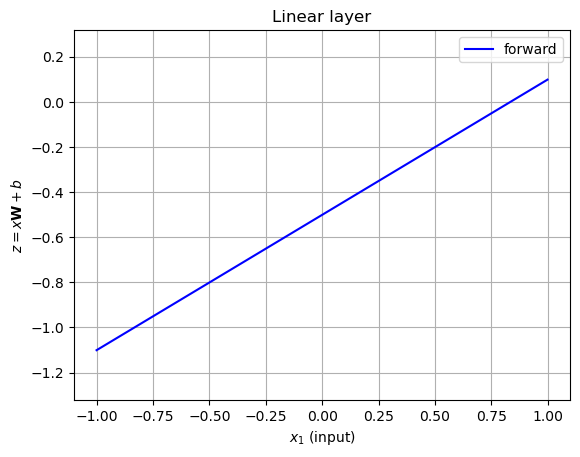

In [3]:
# set data for visualization
x_visualization = np.linspace(-1, 1, n_data * input_dim).reshape(n_data, input_dim)

# forward pass of linear layer
forward_output = linear_layer.forward(x_visualization)

# visualize results
visualize_xy([(x_visualization[:, 0], forward_output[:, 0])], 
             ['forward'], 
             title='Linear layer',
             xlabel='$x_1$ (input)', 
             ylabel='$z = x\mathbf{W} + b$', 
             axis='equal', 
             grid=True, 
             linestyle='b', 
             save_filepath='layer_linear_forward.png')

The forward pass works, so let's implement the backward pass of the `Linear` layer.

In [4]:
# run forward pass to make sure variables stored in the layer are up to date
_ = linear_layer.forward(x_linear)

# Define gradient of loss wrt layer output
dL_wrt_output = np.array([[1., 1.33333333],
                          [1.66666667, 2. ]])

# backward pass of linear layer (computation of gradient of loss wrt layer input)
dL_wrt_x = linear_layer.backward(dL_wrt_output)

# Check if the results are correct
testing.assert_array_almost_equal([[1.8, -0.06666667, -1.93333333],
                                   [ 2.86666667, -0.06666667, -3.]],
                                  dL_wrt_x,
                                  decimal=6,
                                  err_msg='The gradient values returned from the backward pass are incorrect.')
testing.assert_array_almost_equal(
    [[[-2., -2.66666667],
    [-1.2, -1.6],
    [-0.4, -0.53333333]],
    [[ 0.66666667, 0.8],
    [ 2., 2.4  ],
    [ 3.33333333,  4.0 ]]], 
    linear_layer.dL_wrt_W, decimal=6, err_msg='The W parameter gradient values populated by the backward pass are incorrect.')

testing.assert_array_almost_equal(
    [[[1., 1.33333333]],
    [[1.66666667, 2.]]],
    linear_layer.dL_wrt_b, decimal=6, err_msg='The b parameter gradient values populated by the backward pass are incorrect.')


### Rectified Linear Unit (ReLU) layer

ReLU is a commonly used non-linear layer which computes $f(\mathbf{x}) = \text{max}(\mathbf{0}, \mathbf{x})$. Both `forward` and `backward` methods are significantly simpler as the layer has no parameters.

Make sure it works for arbitrarily shaped inputs (even 3D, 4D, or more-D)!


In [5]:
# create instance of ReLU layer
relu_layer = ReLU()

# create sample input data
x_relu = np.array([[-2.,  -1.2, -0.4], 
                   [0.4,  1.2,  2.]])

# forward pass of ReLu layer
forward_output = relu_layer.forward(x_relu)

# check if the result is correct
testing.assert_array_almost_equal([[0, 0, 0], [0.4,  1.2,  2.]], forward_output, decimal=6, err_msg='The values returned from the forward pass are incorrect.')

Now visualize the layer output over a range of inputs.

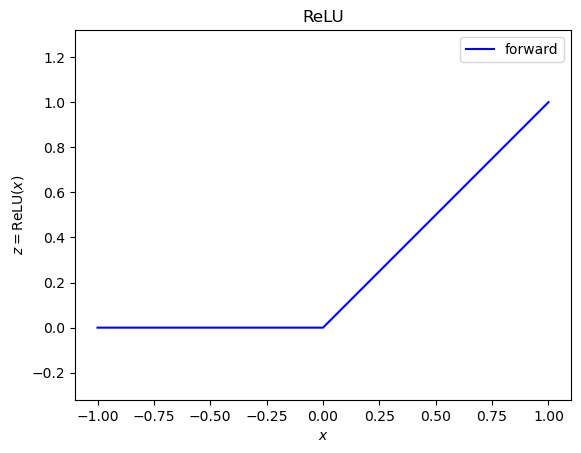

In [6]:
# set data
x_visualization = np.linspace(-1,1,n_data)

# compute the forward pass
forward_output = relu_layer.forward(x_visualization)

# visualize results
visualize_xy([(x_visualization, forward_output)], 
             ['forward'], 
             title='ReLU', 
             axis='equal', 
             xlabel='$x$', 
             ylabel='$z=$ReLU$(x)$', 
             linestyle='b', 
             Tgrid=True, 
             save_filepath='layer_relu_forward.png')

Let's implement the backward pass of the `ReLU` layer. The `backward` method computes only the gradient of the loss w.r.t. the layer inputs this time.

In [7]:
# run forward pass to make sure variables stored in the layer are up to date
_ = relu_layer.forward(x_relu)

# Define sample gradient of loss wrt layer output
dL_wrt_output_relu = np.array([[-3.,  1.2, -0.5], 
                               [ -0.4,  2.2,  3. ]])


# backward pass of ReLU layer (computation of gradient of loss wrt layer input)
dL_wrt_x_relu = relu_layer.backward(dL_wrt_output_relu)

# Check if the results are correct
testing.assert_array_almost_equal([[ 0.,   0.,   0. ],
                                   [-0.4,  2.2,  3. ]],
                                   dL_wrt_x_relu,
                                   decimal=6, err_msg='The gradient values returned from the backward pass are incorrect.')

### Sigmoid layer

You already know the logistic sigmoid from the logistic regression lab.  The `Sigmoid` layer implements the function $f(\mathbf{x}) = \frac{1}{1 + e^{-\mathbf{x}}}$.  As in the ReLU layer, there are no parameters in the `Sigmoid` layer. The `backward` method gain only computes the gradient of the loss w.r.t. the layer inputs.

In [8]:
# create instance of Sigmoid layer
sigmoid_layer = Sigmoid()

# create sample input data
x_sigmoid = np.array([[-2.,  -1.2, -0.4], 
                      [ 0.4,  1.2,  2. ]])

# forward pass of Sigmoid layer
forward_output = sigmoid_layer.forward(x_sigmoid)

# check if the result is correct
testing.assert_array_almost_equal([[0.119203, 0.231475, 0.401312],
                                  [0.598688, 0.768525, 0.880797]], forward_output, decimal=6, err_msg='The values returned from the forward pass are incorrect.')

Again, visualize the output over a range of inputs.

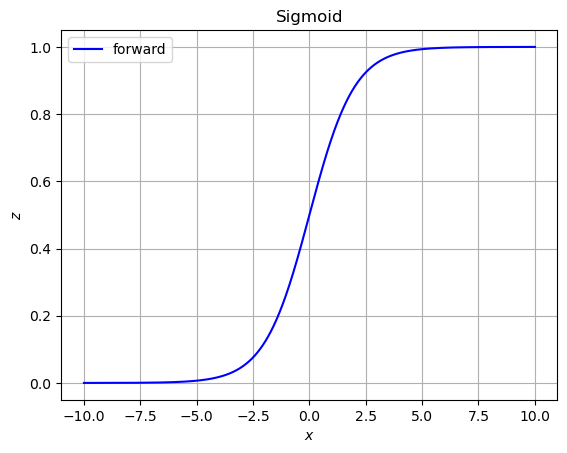

In [9]:
# set data
x_visualization = np.linspace(-10,10,n_data)

# compute forward pass sigmoid
forward_output = sigmoid_layer.forward(x_visualization)

# visualize results
visualize_xy([(x_visualization, forward_output)], 
             ['forward'], 
             title='Sigmoid', 
             xlabel='$x$', 
             ylabel='$z$', 
             grid=True, 
             linestyle='b', 
             save_filepath='layer_sigmoid_forward.png')

Now implement the backward pass of the `Sigmoid` layer.

In [10]:
# run forward pass to make sure variables stored in the layer are up to date
_ = sigmoid_layer.forward(x_sigmoid)

# Define sample gradient of loss wrt layer output
dL_wrt_output_sigmoid = np.array([[-3.,  1.2, -0.5], 
                                  [ -0.4,  2.2,  3. ]])

# compute backward pass of Sigmoid layer
dL_wrt_x_sigmoid = sigmoid_layer.backward(dL_wrt_output_sigmoid)

# Check if the results are correct
testing.assert_array_almost_equal([[-0.314981,  0.213473, -0.12013 ],
                                   [-0.096104,  0.391368,  0.314981]],
                                  dL_wrt_x_sigmoid,
                                  decimal=6, err_msg='The gradient values returned from the backward pass are incorrect.')

### Squared Error loss

The final ingredient of our network is the **loss function**, which compares actual network output $\mathbf{y}$ with the expected output $\mathbf{y}_{gt}$. In our network, we will use Squared Error (SE) loss, which is computed as $L(\mathbf{y}, \mathbf{y}_{gt}) = (\mathbf{y}-\mathbf{y}_{gt})^2$. Start by implementing its `forward` method.

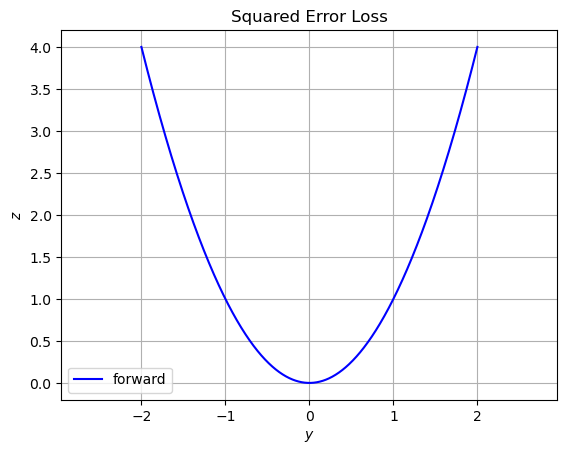

In [11]:
# set input data and ground truth data
y = np.linspace(-2, 2, 1001)
y_gt = 0 * y

# create instance of Squared Error Loss layer
se_layer = SE()

# compute SE loss
loss_se = se_layer.forward(y, y_gt)

# visualize results
visualize_xy([(y, loss_se)], 
             ['forward'], 
             title='Squared Error Loss', 
             axis='equal', 
             xlabel='$y$', 
             ylabel='$z$', 
             linestyle='b', 
             grid=True, 
             save_filepath='layer_se_forward.png')

The `backward` method computes the gradient of the loss only w.r.t. the input $\mathbf{y}$.

In [12]:
# set gradient of loss wrt layer output
n_data_bw = 9
dL_wrt_output_se = np.linspace(-10, 10, n_data_bw)

# set forward pass data and computation
y = np.linspace(-5, 5, n_data_bw)
y_gt = 0.5 * y
_ = se_layer.forward(y, y_gt)

# compute backward pass ReLU
dL_wrt_y = se_layer.backward()

# Check if the results are correct
testing.assert_array_almost_equal([-5., -3.75, -2.5, -1.25, 0., 1.25, 2.5, 3.75, 5.],
                                  dL_wrt_y,
                                  decimal=6, err_msg='The gradient values returned from the backward pass are incorrect.')

### Training the network

Your task is to train the network for a binary classification of two selected classes (digits) from the MNIST dataset.


Start by loading the data for training and validation.

In [13]:
class_a = 4
class_b = 9

(X_trn, y_trn), (X_tst, y_tst) = load_data('full-mnist.npz',
                                           class_a,
                                           class_b)

N_trn, D = X_trn.shape
assert D == 28 * 28
assert y_trn.shape == (N_trn, 1)

# Shuffle the data
trn_indices = np.arange(N_trn)
np.random.shuffle(trn_indices)
X_trn = X_trn[trn_indices, :]
y_trn = y_trn[trn_indices, :]

Define the network structure (the model)

In [14]:
raise NotImplementedError("Experiment with the model architecture.")
model = [Linear(D, 5), ReLU(), Linear(5, 1), Sigmoid()]
trn_head = SE()

Define the training configuration (also known as hyper-parameters).

Make sure to experiment with the hyper-parameter settings (e.g.: Slow training? Try increasing `learning_rate`. No convergence? Try decreasing `learning_rate`) and the `model` network architecture above. A typical model has several layers organised as Linear -> ReLU -> Linear -> ReLU -> ... -> Linear -> Sigmoid, but many other options are possible.
  - Does adding more fully-connected layers help?
  - Does having more output units in the fully-connected layer help?
  - What activation functions work the best?
  - Experiment with the batch size and watch how it influences the training.
  - Feel free to implement also other layers and non-linearities.

In [15]:
raise NotImplementedError("You have to set hyperparameters yourself.")
learning_rate = None
batch_size = None
N_epochs = 90
validation_set_fraction = 0.5


**And start the training!**

*You do not need to modify the following training block of code, but make sure you read it carefully and you understand it.*

In [16]:
print_each = 5 # loss printing setting - (you can modify this)

# Split into train/val
idx_split = int(np.round(N_trn * validation_set_fraction))

X_val = X_trn[:idx_split, :]
X_trn = X_trn[idx_split:, :]
N_trn = X_trn.shape[0]
N_val = X_val.shape[0]

y_val = y_trn[:idx_split, :]
y_trn = y_trn[idx_split:, :]

# The training loop
model_best_params = []
trn_losses = []
val_losses = []
best_val_loss_epoch = 0

batch_count = int(np.ceil(N_trn / batch_size))
for epoch in range(N_epochs):
    try:
        cumulative_epoch_trn_loss = 0 # just for reporting progress
        time_start = time.time()
        for batch_i in range(batch_count):
            # load the minibatch:
            batch_idx = range(batch_i * batch_size,
                              min(N_trn, (batch_i + 1) * batch_size))

            activation = X_trn[batch_idx]

            # forward pass:
            for layer in model:
                activation = layer.forward(activation)

            loss = trn_head.forward(activation, y_trn[batch_idx])
            trn_loss = loss.mean()

            cumulative_epoch_trn_loss += trn_loss

            # backward pass:
            grad_output = trn_head.backward()
            for layer in reversed(model):
                grad_output = layer.backward(grad_output)

            # Update the weights with gradient descent
            for layer in model:
                for param_name, param_value in layer.params().items():
                    param_value -= learning_rate * layer.grads()[param_name].mean(axis=0) # mean across the minibatch

        # validation
        activation = X_val.copy()
        for layer in model:
            activation = layer.forward(activation)
        val_losses.append(trn_head.forward(activation, y_val).mean())

        # remember the best model so far
        if len(val_losses) == 0 or val_losses[-1] < val_losses[best_val_loss_epoch]:
            best_val_loss_epoch = epoch
            model_best_params = [copy.deepcopy(layer.params()) for layer in model]

        trn_losses.append(cumulative_epoch_trn_loss / batch_count)
        if (epoch+1) % print_each == 0 or epoch == 0:
            print("[{:04d}/{:04d}][TRN] MSE loss {:2f} ({:.1f}s)".format(epoch+1, N_epochs, trn_losses[-1], time.time() - time_start))
            print("[{:04d}/{:04d}][VAL] MSE loss {:2f}".format(epoch+1, N_epochs, val_losses[-1]))
    except KeyboardInterrupt:
        print('Early exit')
        break

[0001/0030][TRN] MSE loss 0.035343 (2.1s)
[0001/0030][VAL] MSE loss 0.017097
[0005/0030][TRN] MSE loss 0.006365 (2.1s)
[0005/0030][VAL] MSE loss 0.008158
[0010/0030][TRN] MSE loss 0.002527 (2.1s)
[0010/0030][VAL] MSE loss 0.007173
[0015/0030][TRN] MSE loss 0.001384 (2.1s)
[0015/0030][VAL] MSE loss 0.007669
[0020/0030][TRN] MSE loss 0.000783 (2.0s)
[0020/0030][VAL] MSE loss 0.006015
[0025/0030][TRN] MSE loss 0.000771 (2.0s)
[0025/0030][VAL] MSE loss 0.005881
[0030/0030][TRN] MSE loss 0.000676 (2.0s)
[0030/0030][VAL] MSE loss 0.005825


Plot training outcome

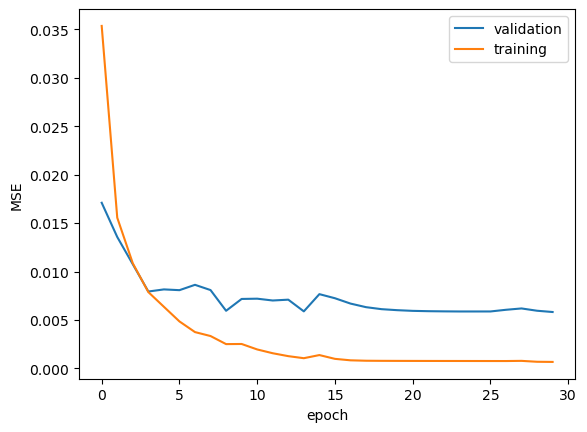

In [17]:
visualize_data([val_losses, trn_losses], legend=['validation', 'training'], xlabel='epoch', ylabel='MSE', save_filepath='numpy_nn_training.png')

Use the best model to classify the test set and show the results

Best VAL model loss 0.0058 at epoch #29.
[TST] MSE loss 0.0079
[TST] error 0.0110


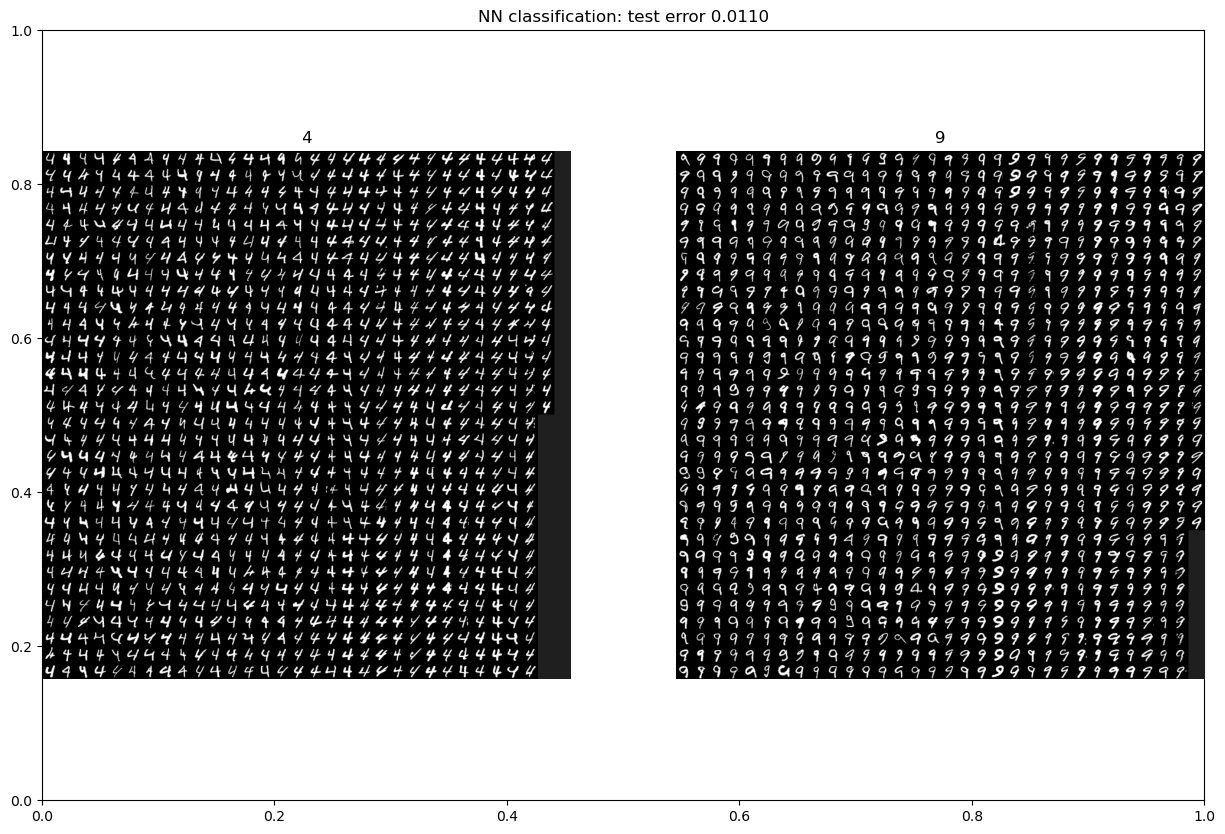

In [18]:
# TST load best model
print('Best VAL model loss {:.4f} at epoch #{:d}.'.format(val_losses[best_val_loss_epoch], best_val_loss_epoch))
for layer_id in range(len(model_best_params)):
    for key, value in model_best_params[layer_id].items():
        model[layer_id].params()[key] = value

# TST forward pass
activation = X_tst
for layer in model:
    activation = layer.forward(activation)
y_hat = (activation > 0.5).astype(int)

loss = trn_head.forward(activation, y_tst)
print("[TST] MSE loss {:.4f}".format(loss.mean()))

test_error = np.mean(y_hat != y_tst)
print("[TST] error {:.4f}".format(test_error))

plt.figure(figsize=(15, 10))
plt.title('NN classification: test error {:.4f}'.format(test_error))
show_classification(X_tst.transpose(1, 0).reshape(28, 28, -1), y_hat.squeeze(), '{}{}'.format(class_a,
                                                                                              class_b))
plt.savefig('numpy_nn_classification.png')
plt.show()

## Part 2: Convolutional Neural Network (CNN) in PyTorch

**In this part, we will be using PyTorch framework for the first time in this course, so make sure you have PyTorch installed as per the [course instructions](https://cw.fel.cvut.cz/wiki/courses/be5b33rpz/labs/python_development#python).**
 
Our simple NumPy NN works well for a simple two digit classification problem, but if we want to solve a more difficult task, it quickly becomes inefficient and then it is better to use one of the highly optimized public libraries. We will work with the currently most popular CNN framework - [PyTorch](https://pytorch.org). Building a neural network using PyTorch is straightforward - there are many layers readily available and you can operate on the data passing through the network just like you would in plain NumPy.

Working with PyTorch should not feel much different from what we just did in NumPy, except all the layers are already implemented for you. Reading through the `pytorch_cnn.py` in the template should give you a good initial idea about PyTorch basics.

We also recommend the documentation (e.g. [PyTorch 1.12 Conv2d documentation](https://pytorch.org/docs/1.12/generated/torch.nn.Conv2d.html#torch.nn.Conv2d)) and the official tutorials:
  * Official [PyTorch introduction course](https://pytorch.org/tutorials/beginner/basics/intro.html). There are step-by-step tutorials, documentation and a possibility of using Google Colab notebooks for learning PyTorch.
  * Official [YouTube playlist](https://www.youtube.com/playlist?list=PL_lsbAsL_o2CTlGHgMxNrKhzP97BaG9ZN) with PyTorch tutorials by Brad Heintz.

In [19]:
%load_ext autoreload
%autoreload 2

import torch
from pytorch_cnn import *
from torchvision import datasets, transforms
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

### Linear classifier, multinomial logistic regression, stochastic gradient descent

Let's start with a simple one layer fully-connected network. You should now understand how the backpropagation works under the hood after the first part of this assignment. Here we will need to extend the binary classification to the multi-class one. Fortunately, this is quite easy using the multinomial logistic regression model. Simply, the predictive probabilities of classes are computed not by sigmoid but by `softmax`:

$$p(y{=}k|s) = {\rm softmax}(s)_k = \frac{e^{s_k}}{\sum_j e^{s_j}},$$

where $s$ is a vector of scores (one per class) computed by the preceding layers of the network. For the purpose of numerical stability it is convenient to adopt the convention that the network should output log probabilities, and use the function `log_softmax` as in the template.

Below we provide a code for training a simple one-layer network `FCNet` with log-softmax. It is trained using the stochastic gradient descent to minimize the negative log likelihood loss (NLL).

**Tasks:**
  - Train the `FCNet` network on FashionMNIST data
  - Add another fully-connected layer with 1000 hidden units and with `Sigmoid` non-linearity. Do you get better results?
  - Try to add more layers. Does the network improve with more and more layers?
  - How many weights do you learn in each case?
  - Try to substitute the sigmoid non-linearity with Rectified Linear Unit (ReLU). It helps to avoid the [vanishing gradient problem](https://medium.com/@karpathy/yes-you-should-understand-backprop-e2f06eab496b#.jusk4zkst).
  - Experiment with the number of layers, number of hidden units and try to get the best possible result.

In [ ]:
learning_rate = 0.001
epochs = 20
batch_size = 16

dataset = datasets.FashionMNIST('data', train=True, download=True,
                                transform=transforms.ToTensor())


trn_size = int(0.09 * len(dataset))
val_size = int(0.01 * len(dataset))
add_size = len(dataset) - trn_size - val_size  # you don't need ADDitional dataset to pass

trn_dataset, val_dataset, add_dataset = torch.utils.data.random_split(dataset, [trn_size,
                                                                                val_size,
                                                                                add_size])
trn_loader = torch.utils.data.DataLoader(trn_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size,
                                         shuffle=False)


device = torch.device("cpu")
model = FCNet().to(device)

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

validation_accuracies = []
for epoch in range(1, epochs + 1):
    # training
    model.train()
    for i_batch, (x, y) in enumerate(trn_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        net_output = model(x)
        loss = F.nll_loss(net_output, y)
        loss.backward()
        optimizer.step()

        if i_batch % 100 == 0:
            print('[TRN] Train epoch: {}, batch: {}\tLoss: {:.4f}'.format(
                epoch, i_batch, loss.item()))

    # validation
    model.eval()
    correct = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)

            prediction = classify(model, x)
            correct += prediction.eq(y).sum().item()
    val_accuracy = correct / len(val_loader.dataset)
    validation_accuracies.append(100. * val_accuracy)
    print('[VAL] Validation accuracy: {:.2f}%'.format(100 * val_accuracy))


visualize_data([validation_accuracies], legend=['validation_accuracy'], xlabel='epoch', ylabel='%', save_filepath='pytorch_fcnet_training.png')

### Convolutional Neural Network

One of the main disadvantages of using the fully-connected layers on images is that they do not take into account the spatial structure of the image. Imagine that you randomly perturb the spatial arrangement of image pixels (same way in both training and test data) and re-train the fully-connected network. These perturbed images become completely unlearnable for humans, since humans make a prior assumption about the spatial arrangement. Nevertheless, the expected testing error of the re-trained fully-connected network on this randomly perturbed dataset will be the same, since it does not make any assumptions and learns the spatial arrangement from the scratch from the perturbed training data. When we learn on images, the architecture of the network should reflect the particular spatial arrangement.

We impose the spatial arrangement by introducing the [convolutional layers](http://cs231n.github.io/convolutional-networks/#conv). The convolution works as shifting a local template (often called a convolution kernel or a local receptive field) over the image and computing its response for every single position in the image. For example, when the input image is 28x28, and we compute convolution with 5x5 kernel, then the resulting response image will be 24x24 (unless we pad the image with zeros). When learned, these templates often corresponds to edge or corner detectors.

Illustration for 3x3 kernel, single input and single output channel ([source](https://mlnotebook.github.io/post/CNN1/)):

<img src="assets/singlechannel-conv.gif" width="400">

Illustration for 3x3 kernel, padding 1, stride 2, three input and two output channels ([source](https://cs231n.github.io/assets/conv-demo/index.html)):

<img src="assets/multichannel-conv.gif" width="600">

Another disadvantage of the fully-connected layers is that the number of parameters grows quickly with new layers. This means significantly more parameters need to be learned and thus more data need to be used to avoid overfitting.

**Tasks:**
  - Train a CNN with one convolutional layer (3x3 kernel) followed by a ReLU non-linearity and a fully connected layer with log-softmax output (see `SimpleCNN` provided in the template).  Notice that the kernel is not evaluated at every position but at every second only (stride=2). This makes the second layer smaller while keeping most of the information present (as nearby convolutions result in similar values). We also added padding=1, which adds zeros to the image before computing the convolution. This way, the size of the output stays the same when stride=1 and becomes half when stride=2.
  - Are you getting better results than with fully connected networks? Does taking into account the spatial arrangement help?
  - How many parameters are you learning now? Compare this to the case of the two layered fully connected network.
  - Add one more convolutional layer with ReLU (again with stride=2).
  - To train a CNN one still needs a lot of data as the number of parameters being estimated is large. To avoid over-fitting, two another techniques are commonly used: [max pooling](http://cs231n.github.io/convolutional-networks/#pool) and [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html). Substitute the stride=2 with stride=1 and add max-pooling. Add a dropout layer before the fully connected layer.
  - In order to overcome the baseline performance and get 8 points implement your network in `MyNet` - exploiting the following techniques should be sufficient:
    * longer training or [one cycle schedule](https://sgugger.github.io/the-1cycle-policy.html)
    * number of layers
    * number and size of the convolutional kernels
    * [data augmentation](https://pytorch.org/vision/stable/transforms.html) to get more data

**Note** that some students prefer training their PyTorch network in [Google Colab](https://colab.research.google.com) cloud using GPU rather than on their own PCs.

In [21]:
# Validate that the MyNet works with correct inputs and output dimensions

batch_size = 64

some_input = torch.rand(batch_size, 1, 28, 28, requires_grad=True)   # Input will be a tensor of size BxCxHxW, which collects gradients for backpropagation
model = MyNet() # Initialise our network
network_output = model(some_input)

# Validate that the network outputs tensors of correct format
assert torch.is_tensor(network_output), 'The network has to output a PyTorch tensor'
assert network_output.requires_grad, 'The output has to collect gradients for backpropagation too'
testing.assert_array_equal(network_output.shape, [batch_size, 10], 'The network should output a tensor of dimensions BxK, where K = 10 classes.')

Start the training and plot the training progress.

In [ ]:
learning_rate = 1.0
epochs = 20

dataset = datasets.FashionMNIST('data', train=True, download=True,
                                transform=transforms.ToTensor())

trn_size = int(0.09 * len(dataset))
val_size = int(0.01 * len(dataset))
add_size = len(dataset) - trn_size - val_size  # you don't need ADDitional dataset to pass

trn_dataset, val_dataset, add_dataset = torch.utils.data.random_split(dataset, [trn_size,
                                                                                val_size,
                                                                                add_size])
trn_loader = torch.utils.data.DataLoader(trn_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size,
                                         shuffle=False)

device = torch.device("cpu")
model = MyNet().to(device)


optimizer = optim.SGD(model.parameters(), lr=learning_rate)


validation_accuracies = []
for epoch in range(1, epochs + 1):
    # training
    model.train()
    for i_batch, (x, y) in enumerate(trn_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        net_output = model(x)
        loss = F.nll_loss(net_output, y)
        loss.backward()
        optimizer.step()

        if i_batch % 100 == 0:
            print('[TRN] Train epoch: {}, batch: {}\tLoss: {:.4f}'.format(
                epoch, i_batch, loss.item()))

    # validation
    model.eval()
    correct = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)

            prediction = classify(model, x)
            correct += prediction.eq(y).sum().item()
    val_accuracy = correct / len(val_loader.dataset)
    validation_accuracies.append(100. * val_accuracy)
    print('[VAL] Validation accuracy: {:.2f}%'.format(100 * val_accuracy))


print('Training completed, final accuracy: {:.2f}%'.format(100 * val_accuracy))
torch.save(model.state_dict(), "model.pt")

visualize_data([validation_accuracies], legend=['validation_accuracy'], xlabel='epoch', ylabel='%', save_filepath='pytorch_cnn_training.png', hline=75.0, hlinelabel='Accuracy threshold (on test set)')

## The challenge

Your `MyNet` network will be automatically evaluated by the [upload system](https://cw.felk.cvut.cz/brute/) and ranked in the online [score board](https://cw.felk.cvut.cz/brute/data/ae/release/2020z_rpz/rpz-2020/upload_system/cnn_leaderboard.php) in real time. __Your network needs to be perform better than the baseline = 75% accuracy on the Test set to pass this lab.__

Note that the accuracy on the test set (which is private and is only used by the evaluation server) might be slightly different than the accuracy on the validation set above. You are supposed to prepare your network using your validation set, not the test set on the server. The number of uploads is limited to 100 attempts by BRUTE, but try to keep it even smaller. If we see unreasonably many uploads for one student, the network could be disqualified as over-fitted to the test data!

The gained points from the assignment depend on the rank of your algorithm (assuming your code passes all the AE tests):
  * 1st place: 16 points
  * 2nd place: 15 points
  * 3rd place: 14 points
  * 4th place: 13 points
  * 5th place: 12 points
  * 6th place: 11 points
  * 7th place: 10 points
  * 8th place:  9 points
  * every submission with performance worse than the baseline (75%): 0 points
  * 8 points otherwise

**Deadline** for the submission is SUNDAY 7th January 2024 23:59. when the points will be assigned. Every later submission is then for 6 points.

In order to achieve the best results __experiment__!

You can try for example (in any order)
* adjust batch size
* [better weights initialisation](http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization)
* pre-training the network on another (larger) dataset
* [improve on the optimisation algorithm](http://ruder.io/optimizing-gradient-descent/)
* [learning rate scheduling](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)
* adding batch normalization
* use GPUs to speed up the training, you can also use the university cluster or Google Colab
* feel free to use any trick you find online or which you invent yourself. Some possibly useful ones:
  * [Tips and tricks for Neural Networks](https://towardsdatascience.com/tips-and-tricks-for-neural-networks-63876e3aad1a) online paper on Towards Data Science web, Pascal Janetzky
  * [Tips and tricks to train neural networks](https://www.lri.fr/~gcharpia/deeppractice/2020/tips.pdf) Berger et al., document from Laboratoire de Recherche en Informatique
  * [Deep Learning Tips and Tricks cheatsheet](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-deep-learning-tips-and-tricks) by Shervine Amidi from Standford University
  * YouTube video called [Nuts and Bolts of Applying Deep Learning](https://www.youtube.com/watch?v=F1ka6a13S9I&ab_channel=LexFridman) by Andrew Ng

## Submission to the BRUTE Upload System

To fulfill this assignment, you need to submit these files (all packed in one `.zip` file) into the __[upload system](https://cw.felk.cvut.cz/brute/)__:

- `cnn.ipynb` - a notebook for data initialisation, calling of the implemented functions and plotting of their results (for your convenience, will not be checked).
- `numpy_nn.py` - containing the following implemented classes:
    - `ReLU` - REctified Linear Unit layer
    - `Linear` - Linear (aka Fully Connected) layer
    - `Sigmoid` - Logistic Sigmoid layer
    - `SE` - Squared Error loss layer
- `numpy_nn_training.png`
- `numpy_nn_classification.png`
- `pytorch_cnn.py` - containing the following implemented classes and methods:
    - `MyNet` - Your CNN model
    - `classify` - classifies data using a trained network
- `pytorch_fcnet_training.png`
- `pytorch_cnn_training.png`
- `model.pt` - trained MyNet state

When preparing a zip file for the upload system, **do not include any directories**, the files have to be in the zip file root.